In [1]:
from notion_client import Client
import os 
import pandas as pd

NOTION = Client(auth=os.environ["NOTION_TOKEN"])
database_id = os.environ["NOTION_DATABASE_ID"]

In [2]:
def query_notion_database(database_id):
    results = []
    has_more = True
    start_cursor = None

    while has_more:
        response = NOTION.databases.query(
            database_id=database_id,
            start_cursor=start_cursor
        )
        results.extend(response["results"])
        has_more = response.get("has_more", False)
        start_cursor = response.get("next_cursor", None)

    return results

In [27]:
def extract_rows(results): 
    rows = []
    for page in results: 
        props = page["properties"]
        row = {
            "id": page["id"],
            "date": props.get("Date", {}).get("date", {}).get("start", None),
            "weight": props.get("Weight", {}).get("number", None),
            "time_of_day": props.get("Time of Day", {}).get("select", {}).get("name", None),
        }
        rows.append(row)

    return pd.DataFrame(rows)

In [28]:
weight_results = query_notion_database(database_id)
weight_df = extract_rows(weight_results)

In [29]:
weight_results

[{'object': 'page',
  'id': '22d911ca-a19c-807f-909f-d2be032df22d',
  'created_time': '2025-07-11T08:14:00.000Z',
  'last_edited_time': '2025-07-11T08:14:00.000Z',
  'created_by': {'object': 'user',
   'id': 'b785c007-12e3-4a0c-b2c3-e61a070792fd'},
  'last_edited_by': {'object': 'user',
   'id': 'b785c007-12e3-4a0c-b2c3-e61a070792fd'},
  'cover': None,
  'icon': {'type': 'external',
   'external': {'url': 'https://www.notion.so/icons/judicial-scales_gray.svg'}},
  'parent': {'type': 'database_id',
   'database_id': '204911ca-a19c-8066-be22-e5efa6127508'},
  'archived': False,
  'in_trash': False,
  'properties': {'Notes': {'id': '%3De~j',
    'type': 'rich_text',
    'rich_text': []},
   'Date': {'id': 'FOaR',
    'type': 'date',
    'date': {'start': '2025-07-11T09:14:00.000+01:00',
     'end': None,
     'time_zone': None}},
   'Time of Day': {'id': '%5BGu%5E',
    'type': 'select',
    'select': {'id': '\\tGW', 'name': 'Morning', 'color': 'yellow'}},
   'Weight': {'id': 'niQS', 'typ

In [30]:
weight_df

,id,date,weight,time_of_day
0,22d911ca-a19c-807f-909f-d2be032df22d,2025-07-11T09:14:00.000+01:00,75.40,Morning
1,22c911ca-a19c-80dd-8705-d52c6b540d46,2025-07-10T23:00:00.000+01:00,75.55,Night
2,22c911ca-a19c-80cd-bb31-f3e5fdc3ecd1,2025-07-10T21:44:00.000+01:00,75.00,Night
3,22c911ca-a19c-80ef-9cff-f639ed442ffc,2025-07-10T11:09:00.000+01:00,76.50,Morning
4,22b911ca-a19c-805b-8f4e-ed3126bb3068,2025-07-09T17:01:00.000+01:00,76.40,Evening
...,...,...,...,...
135,205911ca-a19c-8071-8335-f51537ae6ae0,2025-06-01T10:17:00.000+01:00,81.90,Morning
136,205911ca-a19c-802b-b561-d2e68d4bdb0f,2025-06-01T09:54:00.000+01:00,81.55,Morning
137,204911ca-a19c-801a-ac40-d8d2012de202,2025-05-31T21:27:00.000+01:00,82.15,Night
138,204911ca-a19c-80d7-967f-e7594af0ce34,2025-05-31T20:20:00.000+01:00,82.65,Night


In [35]:
weight_df.columns

Index(['id', 'date', 'weight', 'time_of_day', 'day'], dtype='object')

In [31]:
weight_df[weight_df["weight"] == 84.37]

,id,date,weight,time_of_day
96,20f911ca-a19c-804a-85c7-edb79da995f3,2025-05-16T19:45:00.000+01:00,84.37,Morning


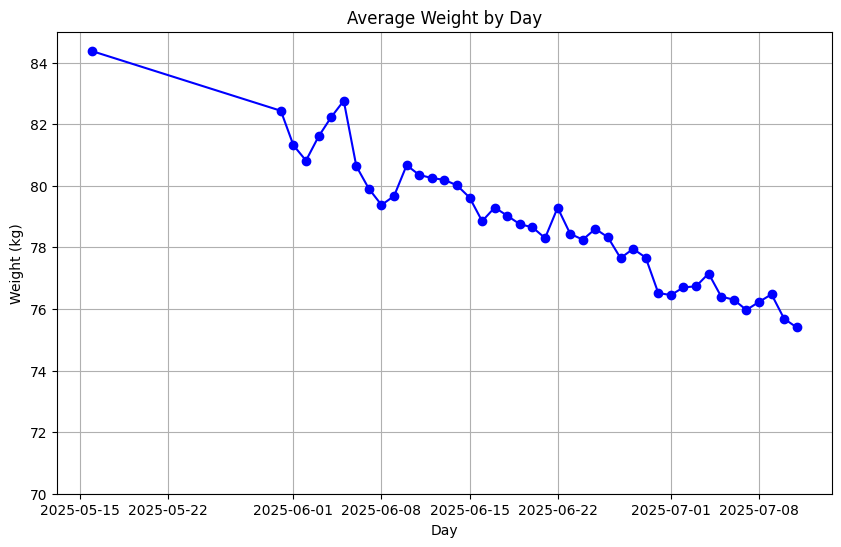

In [34]:
import matplotlib.pyplot as plt

# Convert 'created_time' to datetime and extract the date
weight_df['date'] = pd.to_datetime(weight_df['date'])
weight_df['day'] = weight_df['date'].dt.date

# Group by day and calculate the average weight
daily_avg_weight = weight_df.groupby('day')['weight'].mean()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_weight.index, daily_avg_weight.values, marker='o', linestyle='-', color='b')
plt.ylim(70, 85)
plt.xlabel('Day')
plt.ylabel('Weight (kg)')
plt.title('Average Weight by Day')
plt.grid(True)
plt.show()